# Trace simulator experiments

This is a trace simulator.

1. We first start creating a NUMBER_OF_TOWERS towers in a random distribution.
2. Then we generate random traces for NUMBER_OF_USERS users through a number of CYCLES.
3. Finally we aggregate the data, the number of users for each tower in each cycle.

In [1]:
import random
import math

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Constants

In [2]:
NUMBER_OF_TOWERS = 100
NUMBER_OF_USERS = 1000
CYCLES = 24

#
# The probability of jumping to another tower with its
# distance is within one of these percentiles
#
PERCENTILES_PROB = [
    (0.05, 0.75),
    (0.15, 0.125),
    (0.30, 0.09375),
    (1.00, 0.03125),
]

### Generator utils

In [3]:
def distance(p1, p2):
    """Distance between two points"""
    return math.sqrt(((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2))

def get_random_trace(distances):
    towers_ids = np.arange(NUMBER_OF_TOWERS)
    
    trace = []
    for cycle in range(CYCLES):
        if cycle == 0:
            # For the first towers the chance of selecting a tower is equally distributed
            trace.append(np.random.choice(towers_ids))
        else:
            #
            # The the next tower the probability changes depending on the distance between
            # the last tower and the others.
            #
            last_tower = trace[cycle - 1]
            switch_tower_prob = [0.8, 0.2] if cycle in range(0, 7) else [0.5, 0.5]

            if np.random.choice([True, False], p=switch_tower_prob):
                #
                # Get distances of last tower to the rest and
                # prevents the same last_tower from being selected
                #
                last_tower_dist = distances[last_tower].drop(last_tower)

                # Define the distances quantiles for the percentiles defined in the settings
                dist_quantiles = np.array([last_tower_dist.quantile(p) for p, _ in PERCENTILES_PROB])

                # For each distance, determine in which quantile that distance fits
                towers_prob = np.array([
                    PERCENTILES_PROB[np.argmin(d >= dist_quantiles + 0.00001)][1]
                    for d in last_tower_dist
                ])

                #
                # Equally divide the percentile probability
                # by the number of towers that fit in that group.
                #
                # For example, if 5 towers fit in the first percentile (top 5%), and the probability
                # for that group is of 0.25, then each tower has a 0.05 (= 0.25 / 5) chance of
                # being the following tower.
                #
                prob_items, prob_items_counts = np.unique(towers_prob, return_counts=True)
                for prob_item, prob_item_count in zip(prob_items, prob_items_counts):
                    towers_prob[towers_prob == prob_item] /= prob_item_count

                # Select a random tower taking into account the probabilities
                possible_towers_ids = distances.index.drop(last_tower)
                trace.append(np.random.choice(possible_towers_ids, p=towers_prob))
            else:
                trace.append(last_tower)
    
    return trace

def generate_user_traces(distances):
    return np.array([get_random_trace(distances) for _ in range(NUMBER_OF_USERS)])

def generate_aggregate_data(traces):
    """Returns how many users were in each step of the cycle based on traces"""
    output = np.zeros((NUMBER_OF_TOWERS, CYCLES))
    for tower in range(NUMBER_OF_TOWERS):
        for user in range(NUMBER_OF_USERS):
            for time in range(CYCLES):
                output[tower][time] += traces[user][time] == tower
    return output

### Generate towers with random positions

In [4]:
towers = np.random.rand(NUMBER_OF_TOWERS, 2)

In [5]:
towers.shape

(100, 2)

### Plot towers positions

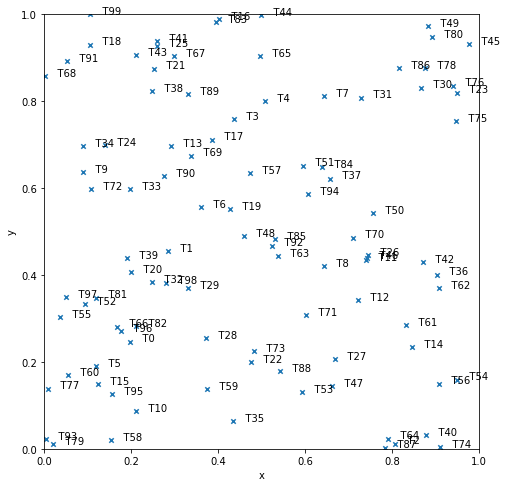

In [6]:
df_towers = pd.DataFrame(towers, columns=['x', 'y'])
ax = df_towers.plot.scatter(x='x', y='y', ylim=(0,1), xlim=(0, 1), figsize=(8, 8), marker='x')

for i in range(len(towers)):
    ax.annotate(f'    T{i}', (df_towers.iloc[i].x, df_towers.iloc[i].y))

plt.gca().set_aspect('equal', adjustable='box')

### Calculate the distances between towers for each tower

In [7]:
distances = pd.DataFrame([
    [distance(towers[i], towers[j]) for j in range(NUMBER_OF_TOWERS)] for i in range(NUMBER_OF_TOWERS)
])

### Show example of tower distance probabilities

Distance quantiles: [0.16823863 0.23300279 0.35120737 0.92755967]


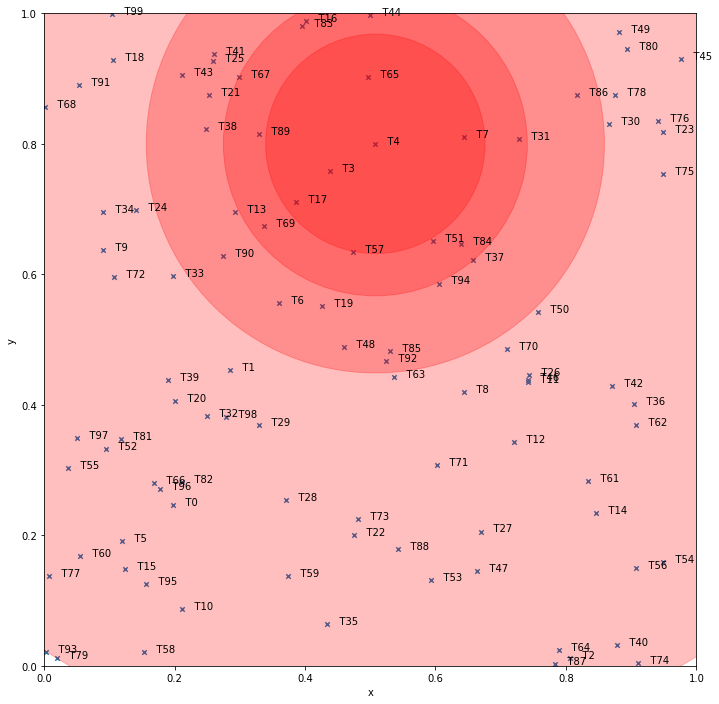

In [8]:
tower_id = 4
tower_dists = distances[tower_id]
dist_quantiles = np.array([tower_dists.quantile(p) for p, _ in PERCENTILES_PROB])
print('Distance quantiles:', dist_quantiles)

df_towers = pd.DataFrame(towers, columns=['x', 'y'])
ax = df_towers.plot.scatter(x='x', y='y', ylim=(0,1), xlim=(0, 1), figsize=(12, 12), marker='x')

for i in range(len(towers)):
    ax.annotate(f'    T{i}', (df_towers.iloc[i].x, df_towers.iloc[i].y))

for r in dist_quantiles:
    ax.add_artist(plt.Circle(towers[tower_id], r, color='r', alpha=1.0 / len(dist_quantiles)))
    
plt.gca().set_aspect('equal', adjustable='box')

## Generate random user traces

We take into account the distances between towers in order to select the following towers

In [9]:
%time random_traces = generate_user_traces(distances)

CPU times: user 26.3 s, sys: 62.6 ms, total: 26.4 s
Wall time: 26.4 s


In [10]:
%time aggregated_data = generate_aggregate_data(random_traces)

print(f'Traces shape: {random_traces.shape}\t aggregated_data shape: {aggregated_data.shape}')

CPU times: user 8.86 s, sys: 21.2 ms, total: 8.88 s
Wall time: 8.9 s
Traces shape: (1000, 24)	 aggregated_data shape: (100, 24)


In [11]:
random_traces

array([[55, 55, 29, ..., 77, 77, 77],
       [36, 61, 54, ..., 29,  1, 39],
       [97, 66, 52, ...,  3, 57, 57],
       ...,
       [40, 61, 42, ..., 11, 70, 70],
       [56, 53, 73, ..., 81, 81, 33],
       [14, 61, 42, ..., 20, 20, 20]])

In [12]:
aggregated_data

array([[ 8.,  8., 14., ..., 12., 17., 18.],
       [14., 13., 16., ..., 24., 15., 17.],
       [10.,  8.,  7., ...,  6.,  3.,  4.],
       ...,
       [ 9.,  8.,  5., ..., 11.,  9., 10.],
       [11., 16., 16., ..., 17., 13., 14.],
       [ 6.,  8.,  6., ...,  2.,  1.,  1.]])

In [13]:
# Check that the sum of users at every cycle is the same
all(aggregated_data.sum(axis=0) == NUMBER_OF_USERS)

True

In [14]:
random_traces[8]

array([26, 26, 46,  4,  4,  3,  3, 89, 17, 17, 69, 69, 69, 90, 17, 89, 24,
       33, 33, 33, 33, 33, 33, 33])

## Draw some random user traces

Cycle #0: Skipping
Cycle #1: Plotting from T55 to T29
Cycle #2: Plotting from T29 to T28
Cycle #3: Plotting from T28 to T22
Cycle #4: Skipping
Cycle #5: Plotting from T22 to T59
Cycle #6: Plotting from T59 to T35
Cycle #7: Plotting from T35 to T73
Cycle #8: Plotting from T73 to T59
Cycle #9: Skipping
Cycle #10: Plotting from T59 to T10
Cycle #11: Skipping
Cycle #12: Plotting from T10 to T58
Cycle #13: Skipping
Cycle #14: Plotting from T58 to T79
Cycle #15: Plotting from T79 to T77
Cycle #16: Plotting from T77 to T79
Cycle #17: Skipping
Cycle #18: Skipping
Cycle #19: Skipping
Cycle #20: Plotting from T79 to T77
Cycle #21: Skipping
Cycle #22: Skipping


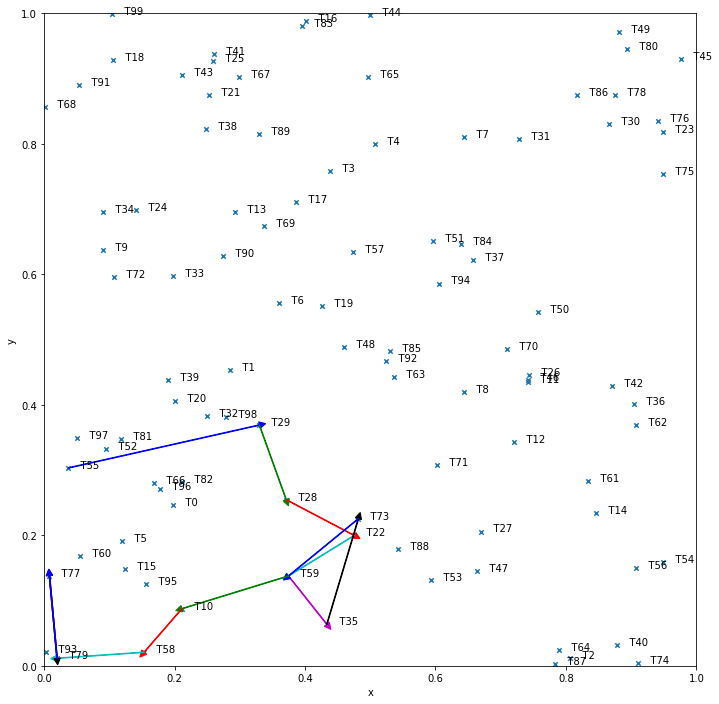

In [15]:
from itertools import cycle

df_towers = pd.DataFrame(towers, columns=['x', 'y'])
ax = df_towers.plot.scatter(x='x', y='y', ylim=(0,1), xlim=(0, 1), figsize=(12, 12), marker='x')

for i in range(len(towers)):
    ax.annotate(f'    T{i}', (df_towers.iloc[i].x, df_towers.iloc[i].y))

cycol = cycle('bgrcmk')

trace = random_traces[0]
for i in range(CYCLES - 1):
    if trace[i] == trace[i + 1]:
        print(f'Cycle #{i}: Skipping')
        continue
    x1, y1 = towers[trace[i]]
    x2, y2 = towers[trace[i + 1]]

    print(f'Cycle #{i}: Plotting from T{trace[i]} to T{trace[i + 1]}')
    color = next(cycol)
    ax.arrow(x1, y1, x2 - x1, y2 - y1, head_width=0.01, head_length=0.01, fc=color, ec=color)

plt.gca().set_aspect('equal', adjustable='box')